In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization,Activation
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.4,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   rotation_range=45,
                                   fill_mode='nearest')

In [5]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',  # Changed from 'binary' to 'categorical'
                                                    shuffle=True, 
                                                    seed=42, 
                                                    color_mode='rgb')


Found 19674 images belonging to 2 classes.


In [8]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', 
                                                   batch_size=32, 
                                                   target_size=(120,120), 
                                                   class_mode='categorical',
                                                   shuffle=False, 
                                                   seed = 42, 
                                                   color_mode = 'rgb')


Found 2158 images belonging to 2 classes.


In [9]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed = 42, 
                                                    color_mode = 'rgb')


Found 2162 images belonging to 2 classes.


In [10]:
x, y = next(train_generator)
print(f"Shape of batch (X): {x.shape}")
print(f"Shape of labels (Y): {y.shape}")


Shape of batch (X): (32, 120, 120, 3)
Shape of labels (Y): (32, 2)


In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# Explicitly define the input shape
input_shape = (120, 120, 3)

# Base Model
base_Neural_Net = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

# Create a Sequential model
model = Sequential()

# Add the base model with pre-trained weights
model.add(base_Neural_Net)

# Freeze the base model layers
for layer in base_Neural_Net.layers:
    layer.trainable = False

# Add custom layers
model.add(Flatten())
model.add(BatchNormalization())  # Add BatchNormalization after Flatten
model.add(Dense(256, kernel_initializer='he_uniform'))
model.add(BatchNormalization())  # Add BatchNormalization before Activation
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))  # Categorical classification output

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for transfer learning
    metrics=['accuracy', 'AUC']
)

# Print the model summary
model.build((None,120,120,3))  # Manually define input shape for model build
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_94 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,498 (91.30 MB)

 Trainable params: 2,114,818 (8.07 MB)

 Non-trainable params: 21,819,680 (83.24 MB)

In [11]:
filepath='model_InceptionV3.keras'
cp = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1, save_best_only=True, save_weights_only=False, mode='max',save_freq='epoch')

In [12]:
EPOCHS = 10
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    batch_size=32,
    epochs=EPOCHS,
    steps_per_epoch=60,
    validation_data=valid_generator,
    callbacks=[es,cp]
)

Epoch 1/10


C:\Users\abhi2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - AUC: 0.7559 - accuracy: 0.6934 - loss: 0.7287
Epoch 1: val_accuracy improved from -inf to 0.81406, saving model to model_InceptionV3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 523ms/step - AUC: 0.7571 - accuracy: 0.6943 - loss: 0.7266 - val_AUC: 0.8923 - val_accuracy: 0.8141 - val_loss: 0.5194
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - AUC: 0.9170 - accuracy: 0.8515 - loss: 0.3782
Epoch 2: val_accuracy improved from 0.81406 to 0.86170, saving model to model_InceptionV3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 426ms/step - AUC: 0.9170 - accuracy: 0.8516 - loss: 0.3783 - val_AUC: 0.9308 - val_accuracy: 0.8617 - val_loss: 0.3638
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - AUC: 0.9341 - accuracy: 0.8547 - loss: 0.3323
Epoch 3: val_accuracy improved from 0.86170 to 0.89223, saving model to model_InceptionV3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 415ms/step - AUC: 0.9339 - accuracy: 0.8546 - loss: 0.3327 - val_AUC: 0.9504 - val_accuracy: 0.

In [13]:
history = model.history.history

In [14]:
import matplotlib.pyplot as plt  # Importing the necessary library

def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


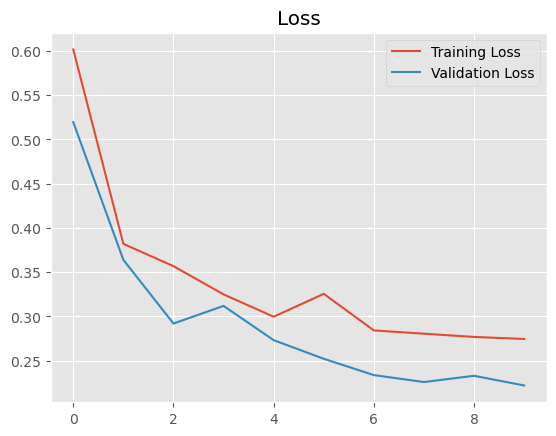

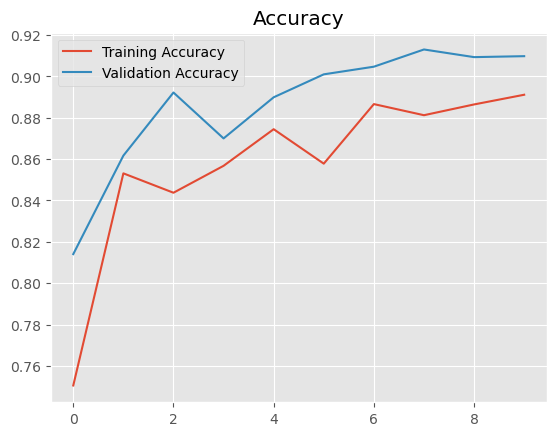

In [15]:
plot_metrics(history) 

In [19]:
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.applications import InceptionV3

# Base Model
base_Neural_Net = InceptionV3(input_shape=(120, 120, 3), weights='imagenet', include_top=False)

for layer in base_Neural_Net.layers:
    layer.trainable = False

for layer in base_Neural_Net.layers[-10:]:
    layer.trainable = True
    
for layer in base_Neural_Net.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Create a Sequential model
model_1 = Sequential()
model_1.add(base_Neural_Net)
model_1.add(Flatten())
model_1.add(BatchNormalization())
model_1.add(Dense(256, kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(2, activation='softmax'))  # Categorical classification output

# Compile the model with a smaller learning rate for fine-tuning
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for fine-tuning
    metrics=['accuracy', 'AUC']
)

model_1.build((None, 120, 120, 3))

# Print the model summary
model_1.summary()



input_layer_8: Trainable = False
conv2d_376: Trainable = False
batch_normalization_384: Trainable = False
activation_380: Trainable = False
conv2d_377: Trainable = False
batch_normalization_385: Trainable = False
activation_381: Trainable = False
conv2d_378: Trainable = False
batch_normalization_386: Trainable = False
activation_382: Trainable = False
max_pooling2d_16: Trainable = False
conv2d_379: Trainable = False
batch_normalization_387: Trainable = False
activation_383: Trainable = False
conv2d_380: Trainable = False
batch_normalization_388: Trainable = False
activation_384: Trainable = False
max_pooling2d_17: Trainable = False
conv2d_384: Trainable = False
batch_normalization_392: Trainable = False
activation_388: Trainable = False
conv2d_382: Trainable = False
conv2d_385: Trainable = False
batch_normalization_390: Trainable = False
batch_normalization_393: Trainable = False
activation_386: Trainable = False
activation_389: Trainable = False
average_pooling2d_36: Trainable = False

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_478              │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_479              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_474 (Activation)          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,498 (91.30 MB)

 Trainable params: 2,115,010 (8.07 MB)

 Non-trainable params: 21,819,488 (83.23 MB)

In [21]:
EPOCHS = 10
est = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=8
)

history_01 = model_1.fit(
    train_generator,
    batch_size=32,
    epochs=EPOCHS,
    steps_per_epoch=60,
    validation_data=valid_generator,
    callbacks=[est,cp]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - AUC: 0.9567 - accuracy: 0.8999 - loss: 0.2691
Epoch 1: val_accuracy did not improve from 0.91304
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 435ms/step - AUC: 0.9567 - accuracy: 0.8998 - loss: 0.2692 - val_AUC: 0.9693 - val_accuracy: 0.9080 - val_loss: 0.2254
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - AUC: 0.9660 - accuracy: 0.9003 - loss: 0.2358
Epoch 2: val_accuracy improved from 0.91304 to 0.92183, saving model to model_InceptionV3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 439ms/step - AUC: 0.9660 - accuracy: 0.9004 - loss: 0.2358 - val_AUC: 0.9745 - val_accuracy: 0.9218 - val_loss: 0.2013
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - AUC: 0.9517 - accuracy: 0.8821 - loss: 0.2840
Epoch 3: val_accuracy did not improve from 0.92183
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 425ms/step - AUC: 0.9517 - accuracy: 0.8821 - loss: 0.2840 - val_AUC: 0.9733 - val_accuracy: 0.9154 - val_loss: 0.2099
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step 

In [22]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

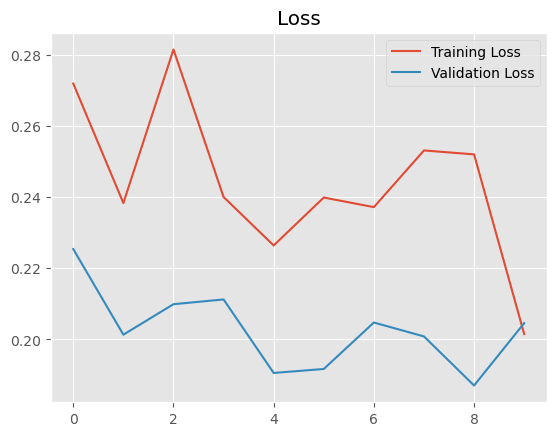

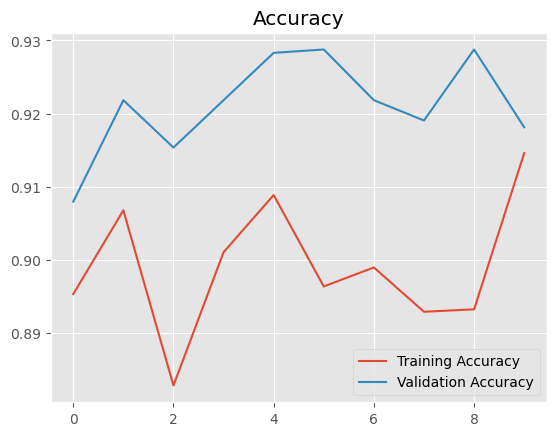

In [23]:
plot_metrics(history_01) 

In [24]:
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.applications import InceptionV3

# Base Model
base_Neural_Net = InceptionV3(input_shape=(120, 120, 3), weights='imagenet', include_top=False)



for layer in base_Neural_Net.layers :
    layer.trainable = True
    
for layer in base_Neural_Net.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Create a Sequential model
model_1 = Sequential()
model_1.add(base_Neural_Net)
model_1.add(Flatten())
model_1.add(BatchNormalization())
model_1.add(Dense(256, kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(2, activation='softmax'))  # Categorical classification output

# Compile the model with a smaller learning rate for fine-tuning
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for fine-tuning
    metrics=['accuracy', 'AUC']
)

model_1.build((None, 120, 120, 3))

# Print the model summary
model_1.summary()


input_layer_10: Trainable = True
conv2d_470: Trainable = True
batch_normalization_480: Trainable = True
activation_475: Trainable = True
conv2d_471: Trainable = True
batch_normalization_481: Trainable = True
activation_476: Trainable = True
conv2d_472: Trainable = True
batch_normalization_482: Trainable = True
activation_477: Trainable = True
max_pooling2d_20: Trainable = True
conv2d_473: Trainable = True
batch_normalization_483: Trainable = True
activation_478: Trainable = True
conv2d_474: Trainable = True
batch_normalization_484: Trainable = True
activation_479: Trainable = True
max_pooling2d_21: Trainable = True
conv2d_478: Trainable = True
batch_normalization_488: Trainable = True
activation_483: Trainable = True
conv2d_476: Trainable = True
conv2d_479: Trainable = True
batch_normalization_486: Trainable = True
batch_normalization_489: Trainable = True
activation_481: Trainable = True
activation_484: Trainable = True
average_pooling2d_45: Trainable = True
conv2d_475: Trainable = Tr

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_574              │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_575              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_569 (Activation)          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,498 (91.30 MB)

 Trainable params: 23,883,170 (91.11 MB)

 Non-trainable params: 51,328 (200.50 KB)

In [25]:
EPOCHS = 10
est = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=8
)

history_01 = model_1.fit(
    train_generator,
    batch_size=32,
    epochs=EPOCHS,
    steps_per_epoch=60,
    validation_data=valid_generator,
    callbacks=[est,cp]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - AUC: 0.7275 - accuracy: 0.6626 - loss: 0.7167
Epoch 1: val_accuracy did not improve from 0.92877
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 876ms/step - AUC: 0.7291 - accuracy: 0.6640 - loss: 0.7143 - val_AUC: 0.7690 - val_accuracy: 0.7146 - val_loss: 1.0956
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - AUC: 0.9255 - accuracy: 0.8592 - loss: 0.3620
Epoch 2: val_accuracy did not improve from 0.92877
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 840ms/step - AUC: 0.9258 - accuracy: 0.8594 - loss: 0.3613 - val_AUC: 0.9065 - val_accuracy: 0.8451 - val_loss: 0.5036
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - AUC: 0.9635 - accuracy: 0.8956 - loss: 0.2469
Epoch 3: val_accuracy did not improve from 0.92877
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 846ms/step - AUC: 0.9635 - accuracy: 0.8955 - loss: 0.2470 - val_AUC: 0.9697 - val_accuracy: 0.9172 - val_loss: 0.2302
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - AUC: 0.9762 - accuracy: 0.9263 - loss: 0.19

In [26]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

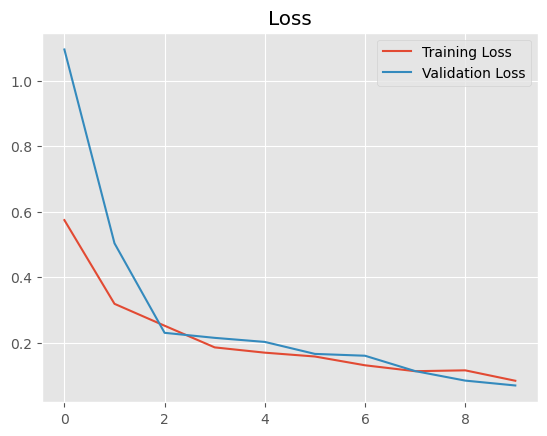

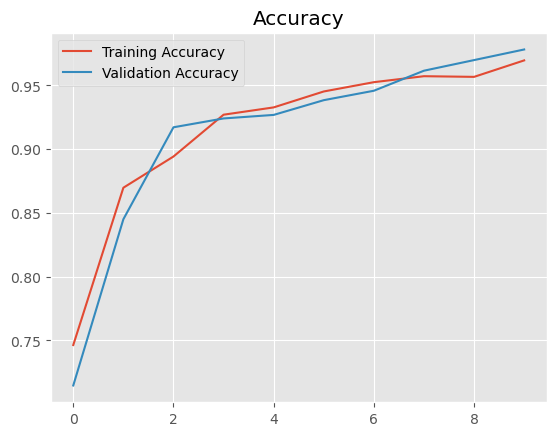

In [27]:
plot_metrics(history_01) 

In [1]:
from tensorflow.keras.models import Model, load_model
model_1=load_model("model_InceptionV3.keras")
model_1.metrics_names

['loss', 'compile_metrics']

In [11]:
metrics = model_1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
auc = metrics[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, AUC: {auc}')

C:\Users\abhi2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - AUC: 0.9985 - accuracy: 0.9889 - loss: 0.0397
Loss: 0.06107970327138901, Accuracy: 0.9782205820083618, AUC: 0.9969826936721802


In [12]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.06107970327138901
Test Accuracy = 0.9782205820083618


In [13]:
predicted_probabilities = model_1.predict(test_generator)[:, 1]

# Set a custom threshold
threshold = 0.5  # Change this value to experiment
adjusted_predictions = (predicted_probabilities >= threshold).astype(int)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_generator.classes, adjusted_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, adjusted_predictions))

68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step
Confusion Matrix:
 [[1071    8]
 [  25 1054]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1079
           1       0.99      0.98      0.98      1079

    accuracy                           0.98      2158
   macro avg       0.98      0.98      0.98      2158
weighted avg       0.98      0.98      0.98      2158

